# 1.Import

In [1]:
import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")
import csv
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical
precision, recall = Precision(), Recall()
from auditokmaster import auditok
from auditok import AudioRegion
import sounddevice as sd
import soundfile as sf
from datetime import datetime
from scipy.signal import resample

Using TensorFlow backend.


# 2.Paths

In [2]:
mainPath ='./database_Google/'
dataPath ='./database_Google/data/'
dataNumpy ='./database_Google/numpy/'
dataNumpy8000 ='./database_Google/numpy/8000/'
dataNumpy16000 ='./database_Google/numpy/16000/'
dataRecord ='./database_Google/Records/'
txtPath ='./database_Google/txt/'

# 3.Load data 

## 3.1Train, validation and test split

### 3.1.1Validation & Test

Here we have a code to extract all file names corresponding to test and validation set

In [3]:
txtFiles= [f for f in os.listdir(txtPath) if f.endswith('.txt')]
print(txtFiles)
#TESTING LIST
testingList = open(txtPath+txtFiles[0], "r")
arrayTest = testingList.readlines()
testingList.close()
print("Length Test:{}".format(len(arrayTest)))
#Remove '\n' from samples
indexArrayTest=0
for i in arrayTest:
    arrayTest[indexArrayTest]=i.rstrip('\n')
    indexArrayTest=indexArrayTest+1
    
    
#VALIDATION LIST
validationList = open(txtPath+txtFiles[1], "r")
arrayVal = validationList.readlines()
validationList.close()
print("Length Validation:{}".format(len(arrayVal)))
#Remove '\n' from samples
indexArrayVal=0
for i in arrayVal:
    arrayVal[indexArrayVal]=i.rstrip('\n')
    indexArrayVal=indexArrayVal+1

['testing_list.txt', 'validation_list.txt']
Length Test:11005
Length Validation:9981


We put together both files in order to substract later this file names in train txt

In [4]:
#Array Test + Validation together
ArrayNotTrain=[]
ArrayNotTrain=np.append(arrayTest,arrayVal)
ArrayNotTrain=list(ArrayNotTrain)

Here we have a function to get unique labels from an array. Also we remove the last two characters from both test and validation list

In [5]:
# function to get unique values 
def unique(list1): 
    # intilize a null list 
    unique_list = [] 
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    return unique_list

In [6]:
#Convert array to list
ArrayNotTrain=list(ArrayNotTrain)
#Sort all samples
ArrayNotTrain.sort(reverse=False)
#Remove '\n' from samples
indexArray=0
for i in ArrayNotTrain:
    ArrayNotTrain[indexArray]=i.rstrip('\n')
    indexArray=indexArray+1
#Remove not unique samples
ArrayNotTrain=unique(ArrayNotTrain)

### 3.1.2 Train

Array label used for appending all file names for all labels

In [7]:
labels=['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 
        'five', 'follow', 'forward', 'four', 'go', 'happy', 'house',
        'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one',
        'right', 'seven', 'sheila', 'six', 'stop','three', 'tree', 
        'two', 'up','visual', 'wow', 'yes', 'zero','_background_noise_']

ArrayLabel=[]
print('Labels:')
for label in labels:
    print(label)
    #Processing all paths
    for f in os.listdir(dataPath + '/'+ label):
            string=''
            if f.endswith('.wav'):
                string=label+'/'+f
                ArrayLabel.append(string)
    
print('Total samples: {}'.format(len(ArrayLabel)))

Labels:
backward
bed
bird
cat
dog
down
eight
five
follow
forward
four
go
happy
house
learn
left
marvin
nine
no
off
on
one
right
seven
sheila
six
stop
three
tree
two
up
visual
wow
yes
zero
_background_noise_
Total samples: 105835


Here we have to remove all file names from Array labels corresponding to both test and validation set, and the result is a rray used for training set

In [8]:
#Convert Array into list
ArrayLabel=list(ArrayLabel)
#Sort all samples
ArrayLabel.sort(reverse=False)
#Remove not unique samples
ArrayLabel=unique(ArrayLabel)

In [9]:
##TRAIN       
#Check which are corresponding to train
ArrayRest=[]
for sample in ArrayNotTrain:
    for labelSample in ArrayLabel:
        if sample==labelSample:
            ArrayLabel.remove(sample)
            ArrayRest.append(sample)

In [10]:
#Check how many samples are for validation and test together
ArrayNew=list(ArrayNotTrain)
for i in ArrayNotTrain:
    for j in ArrayRest:
        if i==j:
            ArrayNew.remove(i)

In [11]:
print('Length Test:{}'.format(len(arrayTest)))
print('Length Validation:{}'.format(len(arrayVal)))
print('Length Train:{}'.format(len(ArrayLabel)))

Length Test:11005
Length Validation:9981
Length Train:84849


# 3.2 Preprocessing data

Here we just load all samples inside the file names in their corresponding train, test and validation sets

In [12]:
all_wave_train = []
all_wave_val = []
all_wave_test = []
all_label_train = []
all_label_val = []
all_label_test = []
#VALIDATION
for wav in arrayVal:
    label,fileName=wav.split('/')
    samples, sample_rate = librosa.load(dataPath  + wav, sr = 8000)
    if(len(samples)== 8000) : 
        all_wave_val.append(samples)
        all_label_val.append(label)
print('Validation completed')
#TEST
for wav in arrayTest:
    label,fileName=wav.split('/')
    samples, sample_rate = librosa.load(dataPath  + wav, sr = 8000)
    if(len(samples)== 8000) : 
        all_wave_test.append(samples)
        all_label_test.append(label)
print('Test completed')
#TRAIN       
for wav in ArrayLabel:
    label,fileName=wav.split('/')
    samples, sample_rate = librosa.load(dataPath + wav, sr = 8000)
    if(len(samples)== 8000) : 
        all_wave_train.append(samples)
        all_label_train.append(label)
print('Train completed')

Validation completed
Test completed
Train completed


In [13]:
#VALIDATION
print('Validation all waves:{}'.format(len(all_wave_val)))
print('Validation all labels:{}'.format(len(all_label_val)))
#TEST
print('Test all waves:{}'.format(len(all_wave_test)))
print('Test all labels:{}'.format(len(all_label_test)))
#TRAIN
print('Train all waves:{}'.format(len(all_wave_train)))
print('Train all labels:{}'.format(len(all_label_train)))

Validation all waves:8947
Validation all labels:8947
Test all waves:10083
Test all labels:10083
Train all waves:76364
Train all labels:76364


In [14]:
# In case you want to save your data
#VALIDATION
np.save(dataNumpy8000+'val_x.npy', all_wave_val)
np.save(dataNumpy8000+'val_labels.npy', all_label_val)
print('Validation saved')
#TRAIN
np.save(dataNumpy8000+'train_x.npy', all_wave_train)
np.save(dataNumpy8000+'train_labels.npy', all_label_train)
print('Train saved')
#TEST
np.save(dataNumpy8000+'test_x.npy', all_wave_test)
np.save(dataNumpy8000+'test_labels.npy', all_label_test)
print('Test saved')

Validation saved
Train saved
Test saved


In [ ]:
### To recorver Data if previously stored and saved
#16000 samples
#VALIDATION
all_wave_val=np.load(dataNumpy8000+'val_x.npy')
all_label_val=np.load(dataNumpy8000+'val_labels.npy')
#TRAIN
all_wave_train=np.load(dataNumpy8000+'train_x.npy')
all_label_train=np.load(dataNumpy8000+'train_labels.npy')
#TEST
all_wave_test=np.load(dataNumpy8000+'test_x.npy')
all_label_test=np.load(dataNumpy8000+'test_labels.npy')

In [15]:
#SHAPES ONCE LOADED NPY
#VALIDATION
print('Shape validation data:{}'.format(len(all_wave_val)))
print('Shape validation label:{}'.format(len(all_label_val)))
#TRAIN
print('Shape train data:{}'.format(len(all_wave_train)))
print('Shape train label:{}'.format(len(all_label_train)))
#TEST
print('Shape test data:{}'.format(len(all_wave_test)))
print('Shape test label:{}'.format(len(all_label_test)))

Shape validation data:8947
Shape validation label:8947
Shape train data:76364
Shape train label:76364
Shape test data:10083
Shape test label:10083


## 3.3 Preprocessing with spectrum

In [16]:
#Preprocess with spectrum
all_wave_train_reshape = []
all_wave_test_reshape = []
all_wave_val_reshape = []
#VALIDATION
for wavval in all_wave_val:
    D2=0
    D2=librosa.power_to_db(librosa.feature.melspectrogram(wavval, sr=8000, n_fft=2048, fmin=10, fmax=10000, n_mels=200), ref=np.max)
    all_wave_val_reshape.append(D2)
#TRAIN
for wavtrain in all_wave_train:
    D2=0
    D2=librosa.power_to_db(librosa.feature.melspectrogram(wavtrain, sr=8000, n_fft=2048, fmin=10, fmax=10000, n_mels=200), ref=np.max)
    all_wave_train_reshape.append(D2)
#TEST
for wavtest in all_wave_test:
    D2=0
    D2=librosa.power_to_db(librosa.feature.melspectrogram(wavtest, sr=8000, n_fft=2048, fmin=10, fmax=10000, n_mels=200), ref=np.max)
    all_wave_test_reshape.append(D2)

In [64]:
print('1 dimension:{}'.format(len(all_wave_test_reshape[0])))
print('2 dimension:{}'.format(len(all_wave_test_reshape[0][0])))

1 dimension:200
2 dimension:16


In [18]:
#VALIDATION
print('Shape validation data:{}'.format(len(all_wave_val_reshape)))
print('Shape validation label:{}'.format(len(all_label_val)))
#TRAIN
print('Shape train data:{}'.format(len(all_wave_train_reshape)))
print('Shape train label:{}'.format(len(all_label_train)))
#TEST
print('Shape test data:{}'.format(len(all_wave_test_reshape)))
print('Shape test label:{}'.format(len(all_label_test)))

Shape validation data:8947
Shape validation label:8947
Shape train data:76364
Shape train label:76364
Shape test data:10083
Shape test label:10083


###### Convert the output labels to integer encoded:

In [19]:
le = LabelEncoder()
#VALIDATION
yVal=le.fit_transform(all_label_val)
classesVal= list(le.classes_)
#TEST
yTest=le.fit_transform(all_label_test)
classesTest= list(le.classes_)
#TRAIN
yTrain=le.fit_transform(all_label_train)
classesTrain= list(le.classes_)

Now, convert the integer encoded labels to a one-hot vector since it is a multi-classification problem:

In [20]:
#VALIDATION
yVal=np_utils.to_categorical(yVal, num_classes=len(classesVal))
#TEST
yTest=np_utils.to_categorical(yTest, num_classes=len(classesTest))
#TRAIN
yTrain=np_utils.to_categorical(yTrain, num_classes=len(classesTrain))


## 3.4 Reshape 

Reshape the 2D array to 3D since the input to the conv1d must be a 3D array

In [22]:
#VALIDATION
all_wave_val_reshape = np.array(all_wave_val_reshape).reshape(-1,200,16)
#TEST
all_wave_test_reshape = np.array(all_wave_test_reshape).reshape(-1,200,16)
#TRAIN
all_wave_train_reshape = np.array(all_wave_train_reshape).reshape(-1,200,16)


In [23]:
print(all_wave_val_reshape.shape)

(8947, 200, 16)


## 3.5 Standard scaler

In [24]:
from sklearn.preprocessing import StandardScaler
scalers = {}
#TRAIN
for i in range(all_wave_train_reshape.shape[1]):
    scalers[i] = StandardScaler()
    all_wave_train_reshape[:, i, :] = scalers[i].fit_transform(all_wave_train_reshape[:, i, :]) 
#VALIDATION    
for i in range(all_wave_val_reshape.shape[1]):
    all_wave_val_reshape[:, i, :] = scalers[i].transform(all_wave_val_reshape[:, i, :]) 
#TEST
for i in range(all_wave_test_reshape.shape[1]):
    all_wave_test_reshape[:, i, :] = scalers[i].transform(all_wave_test_reshape[:, i, :]) 

# 4. Analysing data

## 4.1 Audio Visualization

samples:(16000,)
sample_rate:16000


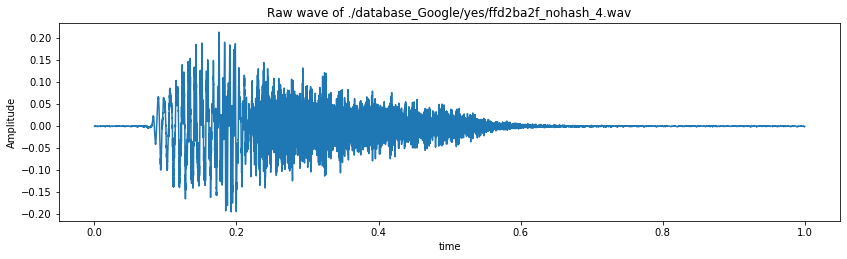

In [26]:
samples, sample_rate = librosa.load(dataPath+'yes/ffd2ba2f_nohash_4.wav', sr = 16000)
print('samples:{}'.format(samples.shape))
print('sample_rate:{}'.format(sample_rate))
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + './database_Google/yes/ffd2ba2f_nohash_4.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, len(samples)/sample_rate, len(samples)), samples)

## 4.2 Sampling and resampling

Here we have an audio sample

In [34]:
ipd.Audio(samples, rate=sample_rate)

Now we can observe how the quality is worse when resampling to a lower sample rate

In [156]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

## 4.3 Analysis of the classes

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero', '_background_noise_']
[1664, 2014, 2064, 2031, 2128, 3917, 3787, 4052, 1579, 1557, 3728, 3880, 2054, 2113, 1575, 3801, 2100, 3934, 3941, 3745, 3845, 3890, 3778, 3998, 2022, 3860, 3872, 3727, 1759, 3880, 3723, 1592, 2123, 4044, 4052, 6]


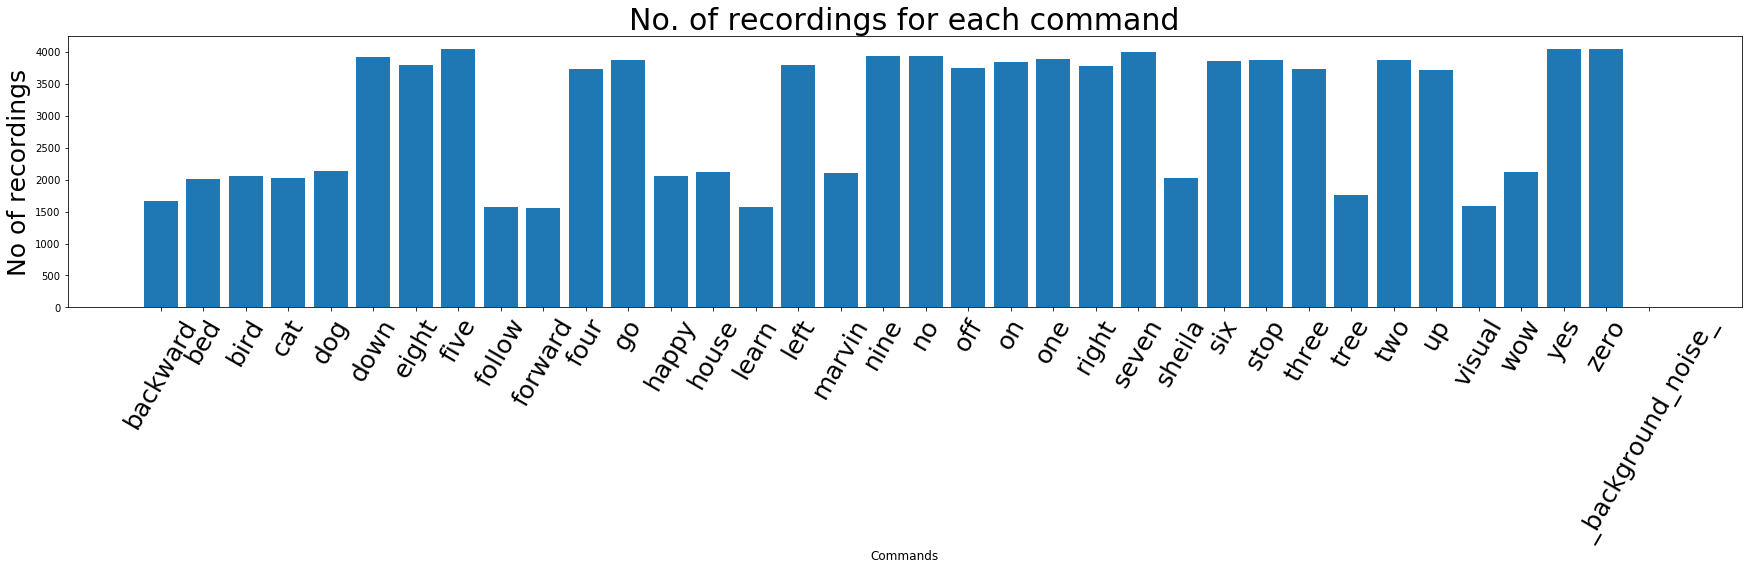

In [34]:
labels=os.listdir(dataPath)
print(labels)
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(dataPath + label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
print(no_of_recordings)
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=25)
plt.xticks(index, labels, fontsize=25, rotation=60)
plt.title('No. of recordings for each command',fontsize=30)
plt.show()

#labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
labels=['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 
        'five', 'follow', 'forward', 'four', 'go', 'happy', 'house',
        'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one',
        'right', 'seven', 'sheila', 'six', 'stop','three', 'tree', 'two', 'up','visual', 'wow', 'yes', 'zero','_background_noise_']

## 4.4 Duration of recordings

In [ ]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(dataPath + label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(dataPath + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))

In [26]:
#Number of samples per digit
n_classes=10
classes=np.zeros((n_classes))
targets=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1']

for label in duration_of_recordings:
    if label<=0.1:
        classes[0]=classes[0]+1
        continue
    if label<=0.2:
        classes[1]=classes[1]+1
        continue
    if label<=0.3:
        classes[2]=classes[2]+1
        continue
    if label<=0.4:
        classes[3]=classes[3]+1
        continue
    if label<=0.5:
        classes[4]=classes[4]+1
        continue
    if label<=0.6:
        classes[5]=classes[5]+1
        continue
    if label<=0.7:
        classes[6]=classes[6]+1
        continue
    if label<=0.8:
        classes[7]=classes[7]+1
        continue
    if label<=0.9:
        classes[8]=classes[8]+1
        continue
    if label<=1:
        classes[9]=classes[9]+1
        continue    

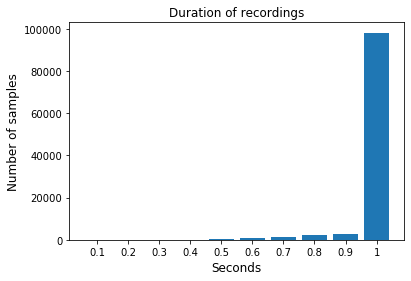

In [35]:
plt.bar(targets,classes)
plt.xlabel('Seconds',fontsize=12)
plt.ylabel('Number of samples',fontsize=12)
plt.title('Duration of recordings')
plt.show()

# 5. Model Building

In [25]:
model=0

In [26]:
from keras.layers import Dense, Dropout, Flatten, Conv2D,Conv1D,  Input, MaxPooling2D,MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(200,16))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(1)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(1)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(1)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(1)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(classesTrain), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 188, 8)            1672      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 188, 8)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 188, 8)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 178, 16)           1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 178, 16)           0         
_____________________

In [27]:
# Previously, we have installed some packages related to plot_model in Keras as pydot
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Early stopping and model checkpoints are the callbacks to stop training the neural network at the right time and to save the best model after every epoch

In [28]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model1.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [29]:
#model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',precision,recall])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [30]:
history=model.fit(all_wave_train_reshape, yTrain ,epochs=100, callbacks=[es,mc], batch_size=100, validation_data=(all_wave_val_reshape,yVal))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 76364 samples, validate on 8947 samples
Epoch 1/100
76364/76364 [==============================] - 57s 745us/step - loss: 2.6903 - acc: 0.2163 - val_loss: 2.1539 - val_acc: 0.4452

Epoch 00001: val_acc improved from -inf to 0.44518, saving model to best_model1.hdf5
Epoch 2/100
76364/76364 [==============================] - 42s 554us/step - loss: 1.9723 - acc: 0.4127 - val_loss: 1.6362 - val_acc: 0.5471

Epoch 00002: val_acc improved from 0.44518 to 0.54711, saving model to best_model1.hdf5
Epoch 3/100
76364/76364 [==============================] - 43s 561us/step - loss: 1.6787 - acc: 0.5023 - val_loss: 1.3227 - val_acc: 0.6199

Epoch 00003: val_acc improved from 0.54711 to 0.61987, saving model to best_model1.hdf5
Epoch 4/100
76364/76364 [==============================] - 44s 572us/step - loss: 1.5151 - acc: 0.5491 - val_loss: 1.1892 - val_acc: 0.6610

Epoch 00004: val_acc improved fr

76364/76364 [==============================] - 36s 469us/step - loss: 0.9706 - acc: 0.7116 - val_loss: 0.7673 - val_acc: 0.7766

Epoch 00038: val_acc did not improve from 0.78429
Epoch 39/100
76364/76364 [==============================] - 36s 469us/step - loss: 0.9596 - acc: 0.7132 - val_loss: 0.7799 - val_acc: 0.7740

Epoch 00039: val_acc did not improve from 0.78429
Epoch 40/100
76364/76364 [==============================] - 36s 469us/step - loss: 0.9530 - acc: 0.7166 - val_loss: 0.7874 - val_acc: 0.7715

Epoch 00040: val_acc did not improve from 0.78429
Epoch 41/100
76364/76364 [==============================] - 36s 469us/step - loss: 0.9474 - acc: 0.7170 - val_loss: 0.7788 - val_acc: 0.7701

Epoch 00041: val_acc did not improve from 0.78429
Epoch 42/100
76364/76364 [==============================] - 36s 469us/step - loss: 0.9544 - acc: 0.7161 - val_loss: 0.8003 - val_acc: 0.7685

Epoch 00042: val_acc did not improve from 0.78429
Epoch 43/100
76364/76364 [===========================

# 6. Diagnostic plot 

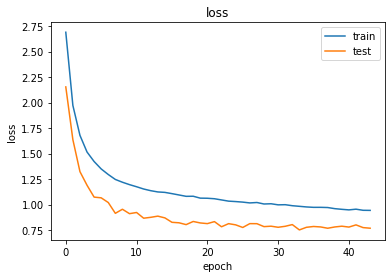

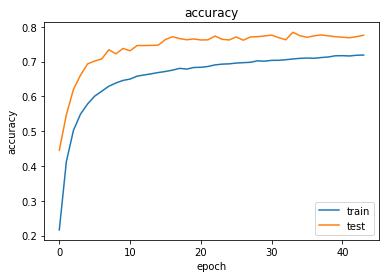

In [32]:
from matplotlib import pyplot
pyplot.title('loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()
pyplot.title('accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.plot(history.history['acc'], label='train') 
pyplot.plot(history.history['val_acc'], label='test') 
pyplot.legend() 
pyplot.show()

# 7. Model persistence

## 7.1 Save and load model with Modelcheckpoint

In [33]:
from keras.models import load_model
#model=load_model('best_model.hdf5')

## 7.2 Save and load with joblib

Save the model to disk

In [34]:
# save the model to disk
import joblib
filename = 'modeljoblib50history.sav'
joblib.dump(history, filename)
print("Saved model to disk")

Saved model to disk


Load the model from disk

In [35]:
loaded_model = joblib.load(filename)
print("Load model from disk")

Load model from disk


## 7.3 Save and load with keras

In [50]:
# save model and architecture to single file
model.save('./models/modelkeras100.h5')
print("Saved model to disk")

Saved model to disk


In [51]:
from keras.models import load_model
model=load_model('./models/modelkeras100.h5')

In [52]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 188, 8)            1672      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 188, 8)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 188, 8)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 178, 16)           1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 178, 16)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 178, 16)           0         
__________

# 8. Prediction

In [99]:
#Predict model
predicted = model.predict(all_wave_test_reshape)
#Conver probs from prediction in an array with just one with is most probable
arrayStringPredicted=[]
indexcounter=0
for i in predicted:
    index=np.argmax(i)
    word=classesTest[int(index)]
    arrayStringPredicted.append(word)
    indexcounter=indexcounter+1
#Array with labels
predicted=arrayStringPredicted

In [100]:
yTest=le.fit_transform(all_label_test)
yTest=np_utils.to_categorical(yTest, num_classes=len(classesTest))

In [101]:
arrayStringyTest=[]
indexcounter=0
for i in yTest:
    index=np.argmax(i)
    word=classesTest[int(index)]
    arrayStringyTest.append(word)
    indexcounter=indexcounter+1
#Array with labels
yTest=arrayStringyTest

In [108]:
def predict(audio):
    prob=model.predict(audio)
    index=np.argmax(prob[0])
    return classesTest[index]

In [109]:
import random
index=random.randint(0,len(all_wave_test_reshape)-1)
samples=all_wave_test_reshape[index]
samples2=samples.reshape(-1,samples.shape[0], samples.shape[1])
print("Target Audio:",yTest[index])
ipd.Audio(samples, rate=8000)
print("Predicted Text:",predict(samples2))

Target Audio: five
Predicted Text: five


# 9. Analysis of the performance and error

## 9.1 Classification report

In [111]:
from sklearn import datasets, svm, metrics
print("Classification report for classifier %s:\n%s\n" % (model, metrics.classification_report(yTest, predicted)))

Classification report for classifier <keras.engine.training.Model object at 0x0000023C685B56D8>:
              precision    recall  f1-score   support

    backward       0.80      0.75      0.78       159
         bed       0.78      0.53      0.63       183
        bird       0.85      0.71      0.78       153
         cat       0.79      0.70      0.74       168
         dog       0.77      0.56      0.65       192
        down       0.71      0.73      0.72       376
       eight       0.75      0.78      0.76       376
        five       0.80      0.68      0.74       408
      follow       0.66      0.61      0.63       165
     forward       0.62      0.54      0.58       147
        four       0.68      0.74      0.71       368
          go       0.65      0.69      0.67       364
       happy       0.81      0.82      0.82       177
       house       0.75      0.81      0.78       167
       learn       0.69      0.56      0.62       149
        left       0.84      0.68     

## 9.2 Confusion matrix

<Figure size 648x648 with 0 Axes>

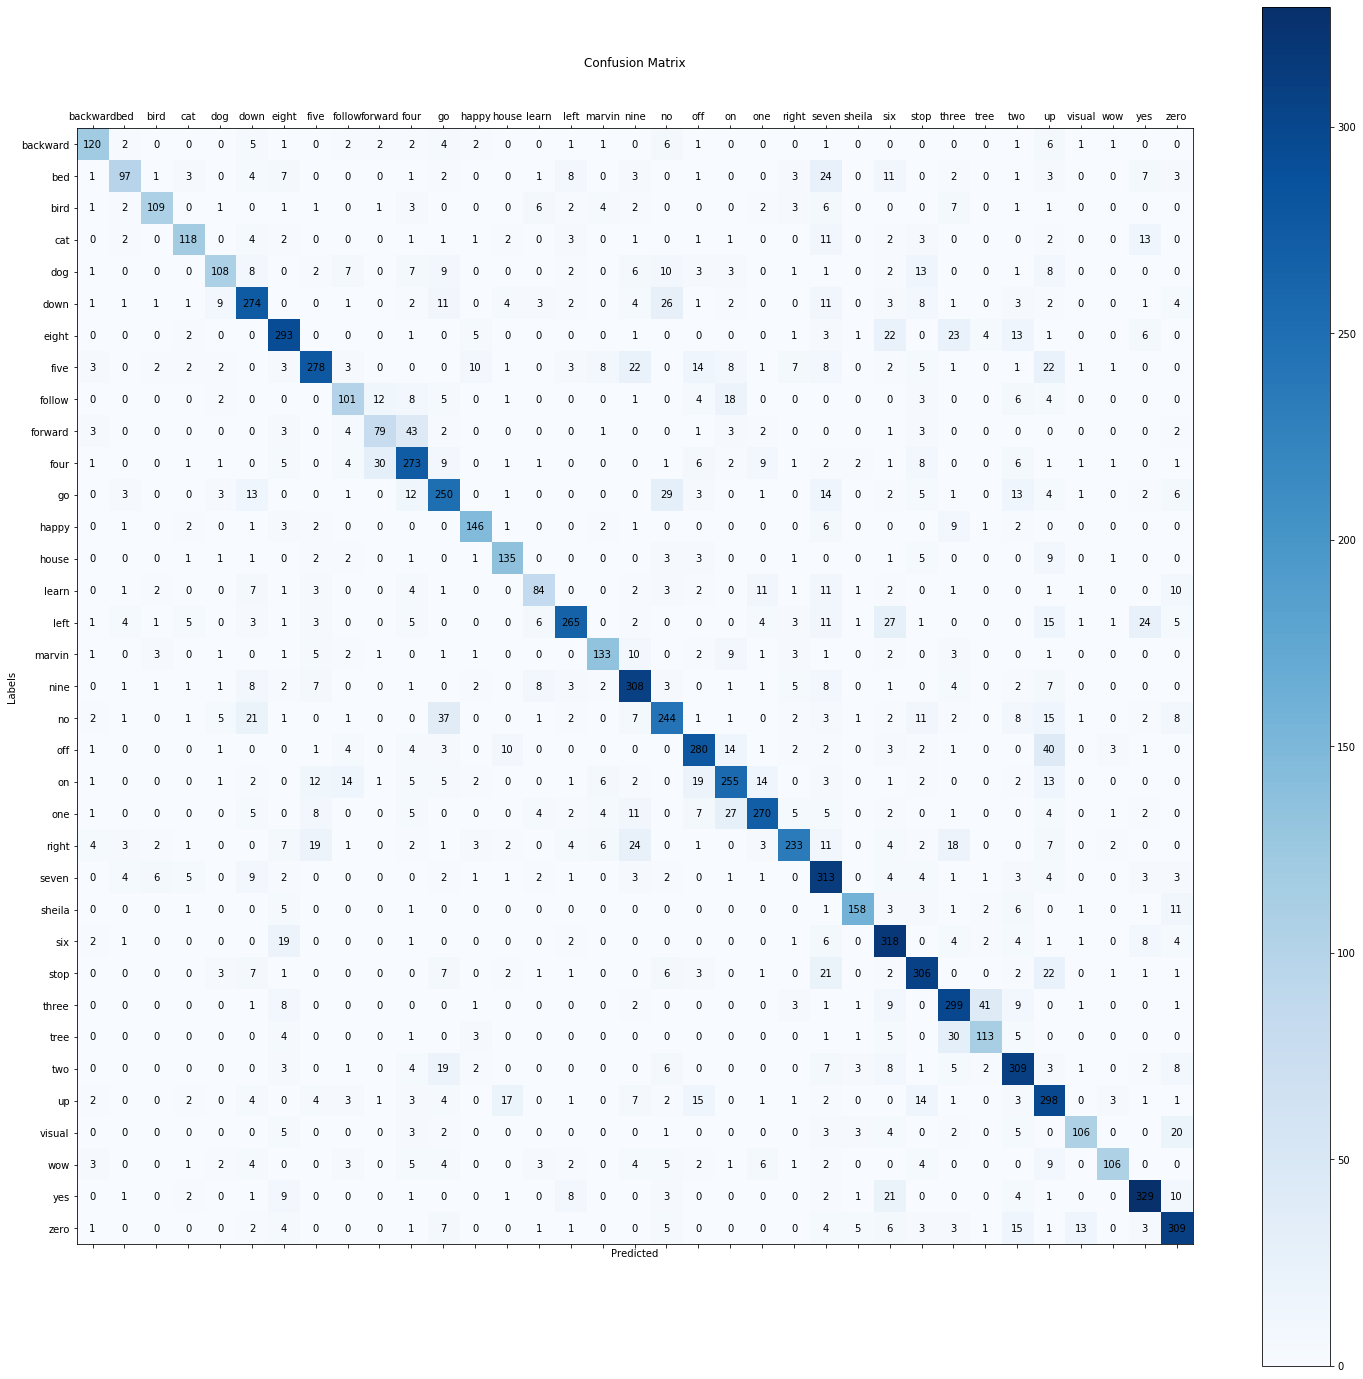

In [112]:
# Es lo mismo pero representa el número de veces que se predice, en vez del porcentaje
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(conf_matrix):
     # Calculate chart area size
    leftmargin = 0.5 # inches
    rightmargin = 0.5 # inches
    categorysize = 0.8 # inches
    sizelabels=10
    figwidth = leftmargin + rightmargin + (sizelabels* categorysize)           
    f = plt.figure(figsize=(figwidth, figwidth))
    labels=['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 
        'five', 'follow', 'forward', 'four', 'go', 'happy', 'house',
        'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one',
        'right', 'seven', 'sheila', 'six', 'stop','three', 'tree', 
        'two', 'up','visual', 'wow', 'yes', 'zero']
    fig = plt.figure(figsize=(25,25))
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_matrix, cmap=plt.get_cmap('Blues'))
    fig.colorbar(cax)
    ax.set_yticks([i for i in range(0,35)])
    ax.set_xticks([i for i in range(0,35)])
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels)
    for (i, j), z in np.ndenumerate(conf_matrix):
        ax.text(j, i, '{}'.format(z), ha='center', va='center')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Labels')
    plt.show()
    
plot_confusion_matrix(confusion_matrix(yTest, predicted))

## 9.3 Prediction training

In [113]:
from sklearn import metrics
#TRAINING
#Predict model
predictedtrain = model.predict(all_wave_train_reshape)
#Conver probs from prediction in an array with just one with is most probable
arrayStringPredictedtrain=[]
indexcounter=0
for i in predictedtrain:
    index=np.argmax(i)
    word=classesTest[int(index)]
    arrayStringPredictedtrain.append(word)
    indexcounter=indexcounter+1
#Array with labels
predictedtrain=arrayStringPredictedtrain
#LABELS
arrayStringyTrain=[]
indexcounter=0
for i in yTrain:
    index=np.argmax(i)
    word=classesTest[int(index)]
    arrayStringyTrain.append(word)
    indexcounter=indexcounter+1
#Array with labels
yTrain=arrayStringyTrain

print("Accuracy in training", metrics.accuracy_score(yTrain, predictedtrain))

Accuracy in training 0.8134330312712796


## 9.4 Prediction testing

In [114]:
yTest=le.fit_transform(all_label_test)
yTest=np_utils.to_categorical(yTest, num_classes=len(classesTest))

In [115]:
from sklearn import metrics
#TESTING
#Predict model
predictedtest = model.predict(all_wave_test_reshape)
#Conver probs from prediction in an array with just one with is most probable
arrayStringPredictedtest=[]
indexcounter=0
for i in predictedtest:
    index=np.argmax(i)
    word=classesTest[int(index)]
    arrayStringPredictedtest.append(word)
    indexcounter=indexcounter+1
#Array with labels
predictedtest=arrayStringPredictedtest

#LABELS
arrayStringyTest=[]
indexcounter=0
for i in yTest:
    index=np.argmax(i)
    word=classesTest[int(index)]
    arrayStringyTest.append(word)
    indexcounter=indexcounter+1
#Array with labels
yTest=arrayStringyTest

y_test_pred = model.predict(all_wave_test_reshape)
print("Accuracy in testing", metrics.accuracy_score(yTest, predictedtest))

Accuracy in testing 0.7355945651095904
